## 1. Supervised Learning

### 1) Prepare dataset & NN

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torchvision.datasets import MNIST
from torch.utils.data import ConcatDataset

%matplotlib inline

# Transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
trainset = MNIST(root='./MNIST', train=True, download=False, transform=transform)
testset = MNIST(root='./MNIST', train=False, download=False, transform=transform)

major_class_num = 420
minor_class_num = 180
images = []
targets = []

for i in range(10):
    class_indices = np.where(np.array(trainset.targets) == i)[0]
    num_samples = major_class_num if i < 3 else minor_class_num
    selected_indices = class_indices[:num_samples]
    
    for idx in selected_indices:
        images.append(trainset[idx][0])
        targets.append(1 if i < 3 else 0)

# Convert to PyTorch tensors
images = torch.stack(images)
targets = torch.tensor(targets, dtype=torch.float32)

# Create a TensorDataset with the selected instances and modified labels
subset = TensorDataset(images, targets.view(-1, 1))

trainloader = DataLoader(subset, batch_size=64, shuffle=True)


# Major 3 classes
major_indices = [idx for idx, label in enumerate(testset.targets) if label in [0, 1, 2]]
major_images = torch.stack([testset[idx][0] for idx in major_indices])
major_targets = torch.tensor([1] * len(major_indices), dtype=torch.float32)
major_test_subset = TensorDataset(major_images, major_targets.view(-1, 1))

# Other classes
other_indices = [idx for idx, label in enumerate(testset.targets) if label not in [0, 1, 2]]
other_images = torch.stack([testset[idx][0] for idx in other_indices])
other_targets = torch.tensor([0] * len(other_indices), dtype=torch.float32)
other_test_subset = TensorDataset(other_images, other_targets.view(-1, 1))

combined_test_dataset = ConcatDataset([major_test_subset, other_test_subset])
testloader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5) # Change the input channel to 1 since MNIST is grayscale
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 128) # Change the input size to match the output of the last convolutional layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # Flatten the output for the fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

net = Net()


### 2) Train & Test

In [3]:
def train_network(trainloader, epochs=10):
    net = Net()
    net.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
    return net


def evaluate(testloader):
    correct = 0
    total = 0
    output_distribution = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            predicted = (outputs > 0.5).float()
            output_distribution.extend(outputs.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy, output_distribution

# def evaluate_with_known_OOD_proportion(testloader, major_count):
#     major_correct = 0
#     other_correct = 0
#     total_major = 0
#     total_other = 0
#     major_output_distribution = []
#     other_output_distribution = []

#     with torch.no_grad():
#         for idx, (images, labels) in enumerate(testloader):
#             images, labels = images.to(device), labels.to(device)
#             outputs = net(images)
#             predicted = (outputs > 0.5).float()
            
#             # Split based on major and other classes
#             if idx * 64 < major_count:
#                 major_output_distribution.extend(outputs.cpu().numpy())
#                 total_major += labels.size(0)
#                 major_correct += (predicted == labels).sum().item()
#             else:
#                 other_output_distribution.extend(outputs.cpu().numpy())
#                 total_other += labels.size(0)
#                 other_correct += (predicted == labels).sum().item()

#     major_accuracy = 100 * major_correct / total_major
#     other_accuracy = 100 * other_correct / (len(combined_test_dataset) - major_count)
#     return major_accuracy, other_accuracy, major_output_distribution, other_output_distribution


def evaluate_with_known_OOD_proportion(testloader, major_count):
    major_correct_adaptive = 0
    other_correct_adaptive = 0
    major_correct_fixed = 0
    other_correct_fixed = 0
    total_major = 0
    total_other = 0
    major_output_distribution = []
    other_output_distribution = []

    with torch.no_grad():
        for idx, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            
            # Record outputs for threshold calculation
            if idx * 64 < major_count:
                major_output_distribution.extend(outputs.cpu().numpy())
            else:
                other_output_distribution.extend(outputs.cpu().numpy())

        # Calculate adaptive threshold
        combined_output_distribution = [item for sublist in major_output_distribution + other_output_distribution for item in sublist]
        threshold_adaptive = sorted(combined_output_distribution)[-major_count]

        # Calculate accuracy using both adaptive and fixed thresholds
        for idx, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted_adaptive = (outputs > threshold_adaptive).float()
            predicted_fixed = (outputs > 0.5).float()
            
            if idx * 64 < major_count:
                total_major += labels.size(0)
                major_correct_adaptive += (predicted_adaptive == labels).sum().item()
                major_correct_fixed += (predicted_fixed == labels).sum().item()
            else:
                total_other += labels.size(0)
                other_correct_adaptive += (predicted_adaptive == labels).sum().item()
                other_correct_fixed += (predicted_fixed == labels).sum().item()

    major_accuracy_adaptive = 100 * major_correct_adaptive / total_major
    other_accuracy_adaptive = 100 * other_correct_adaptive / total_other
    major_accuracy_fixed = 100 * major_correct_fixed / total_major
    other_accuracy_fixed = 100 * other_correct_fixed / total_other

    adaptive_average_accuracy = (major_accuracy_adaptive + other_accuracy_adaptive) / 2
    fixed_average_accuracy = (major_accuracy_fixed + other_accuracy_fixed) / 2
    threshold_adaptive = round(threshold_adaptive, 3)

    return fixed_average_accuracy, adaptive_average_accuracy, major_output_distribution, other_output_distribution, threshold_adaptive


Iteration 1:
Iteration 11:
Iteration 21:
Iteration 31:
Iteration 41:
Iteration 51:
Iteration 61:
Iteration 71:
Iteration 81:
Iteration 91:


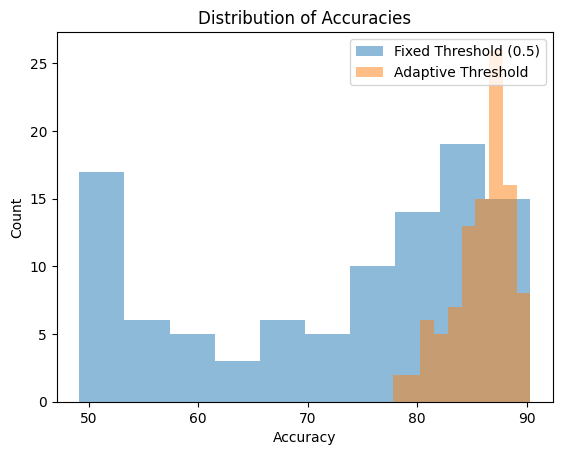

In [5]:
import numpy as np
import matplotlib.pyplot as plt

fixed_threshold_accuracies = []
adaptive_threshold_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for iteration in range(100):
    if iteration % 10 == 0:
        print(f"Iteration {iteration}:")

    net = train_network(trainloader)
    
    Fixed_threshold_accuracy, Adaptive_threshold_accuracy, major_output_distribution, other_output_distribution, threshold = evaluate_with_known_OOD_proportion(testloader, len(major_test_subset))

    major_output_distribution = np.array(major_output_distribution).flatten()
    other_output_distribution = np.array(other_output_distribution).flatten()

    # print(f'major class: {major_class_num}, minor class: {minor_class_num}')
    # print('Accuracy for threshold 0.5:', Fixed_threshold_accuracy, '%')
    # print('Accuracy for adaptive threshold:', Adaptive_threshold_accuracy, '%')

    # Save the accuracies for later plotting
    fixed_threshold_accuracies.append(Fixed_threshold_accuracy)
    adaptive_threshold_accuracies.append(Adaptive_threshold_accuracy)
    
avg_fixed_accuracy = np.mean(fixed_threshold_accuracies)
avg_adaptive_accuracy = np.mean(adaptive_threshold_accuracies)
print(f'avg_fixed_accuracy: {avg_fixed_accuracy}')
print(f'avg_adaptive_accuracy: {avg_adaptive_accuracy}')

# Plot the accuracy distributions
plt.hist(fixed_threshold_accuracies, bins=10, alpha=0.5, label='Fixed Threshold (0.5)')
plt.hist(adaptive_threshold_accuracies, bins=10, alpha=0.5, label='Adaptive Threshold')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.title('Distribution of Accuracies')
plt.legend(loc='upper right')
plt.show()



    # # Plotting the distribution for major and minor classes
    # plt.hist(major_output_distribution, bins=50, density=True, alpha=0.5, label='Major 3 classes')
    # plt.hist(other_output_distribution, bins=50, density=True, alpha=0.5, label='Other classes')
    # plt.xlabel('Model Output')
    # plt.ylabel('Density')
    # plt.title(f'Distribution of Model Outputs')
    # plt.axvline(x=0.5, color='red', label='Threshold 0.5')
    # plt.axvline(x=threshold, color='green', label=f'Adaptive Threshold')# {threshold}')
    # plt.legend(loc='upper right')
    # # plt.savefig(f'output_distribution_{iteration}.png') # Save plot as image with iteration number
    # plt.show()
